In [1]:
import numpy as np
import os 
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Rescaling and Padding Images

In [2]:
def pad2(img, target_length=224):
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_target = np.zeros((target_length, target_length, 3), np.uint8) #<-- use this to build datase
    
    copy_loc_h = (target_length-img_height) // 2
    copy_loc_w = (target_length-img_width) // 2
    img_target[copy_loc_h:copy_loc_h+img_height, copy_loc_w:copy_loc_w+img_width,:] = img

    return img_target

# Save a specific image to specified directory

In [3]:
def save_img(img, save_dir):
    img = Image.fromarray(img)
    if not os.path.exists(save_dir):
        img.convert("RGB").save(save_dir)

# Reverse padded images to cropped ships

(128, 32, 3)


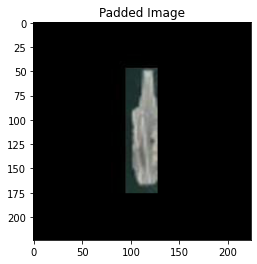

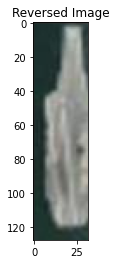

In [7]:
"""
REVERSE THE IMAGE BY SAMPLE (INDIVIDUALLY)
"""

def reverse_img(img):
    img_merge = img[:,:,0] + img[:,:,1] + img[:,:,2] # merge 3 channels
    binary = (img_merge != 0).astype(int) # check locations of active and dead neurons
    x_min=0; x_max = 0
    y_min=0; y_max = 0
    
    for i in range(224):
        if(img_merge[112][i] > 35):
            x_min = i
            break
            
    for i in range(223,0,-1):
        if(img_merge[112][i] > 35):
            x_max = i
            break
            
    for j in range(224):
        if(img_merge[j][112] > 35):
            y_min = j
            break
            
    for j in range(223,0,-1):
        if(img_merge[j][112] > 35):
            y_max = j
            break
    
    img_reversed = img[y_min:y_max, x_min:x_max,:]
    
    return img_reversed
    
"""
Execution
"""  
img = plt.imread("./Downloads/Sat2/Resolutions/Data-MS-Pad-NoCS/Train/Carrier/3_carrier1_2.jpg")   
plt.figure()
plt.title("Padded Image")
plt.imshow(img)

img_reversed = reverse_img(img)
plt.figure()
plt.title("Reversed Image")
plt.imshow(img_reversed)
print(img_reversed.shape)

In [8]:
"""
REVERSE THE IMAGE BY BATCH
"""

def reverse_img_batch(data_dir, target_dir):
    for train_test in os.listdir(data_dir):
        for classes in os.listdir(os.path.join(data_dir, train_test)):
            for img_name in os.listdir(os.path.join(data_dir, train_test, classes)):
                img_dir = os.path.join(data_dir, train_test, classes, img_name)
                save_dir = os.path.join(target_dir, train_test, classes, img_name)
                
                img = plt.imread(img_dir)
                plt.imshow(img)
                try:
                    img_reversed = reverse_img(img=img)
                    save_img(img=img_reversed, save_dir=save_dir)
                except Exception:
                    print(img_name)
                

v1_rotated_h_war56_5.jpg
v1_flip_h_war56_5.jpg
v1_rotated_war56_5.jpg


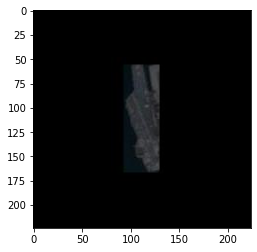

In [9]:
"""
Execution
"""
reverse_img_batch(data_dir="./Downloads/Sat2/Resolutions/Data-MS-Pad-NoCS",
                 target_dir="./Downloads/Sat2/Resolutions/Cropped-Ships") 

# Investigate dead neurons in feature vector

In [11]:
"""
    Initialize model and load trained weights
"""

model = models.resnet34(pretrained=False)
#model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 6)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(256, 6)
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("./Downloads/Sat2/Models/Phase4_res34_fc512_256_6.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Ship scale: 148 by 27 (pixel^2)
26 dead neurons.

***********************************************
Ship scale: 121 by 31 (pixel^2)
11 dead neurons.

***********************************************
Ship scale: 72 by 9 (pixel^2)
26 dead neurons.

***********************************************
Ship scale: 25 by 12 (pixel^2)
35 dead neurons.

***********************************************


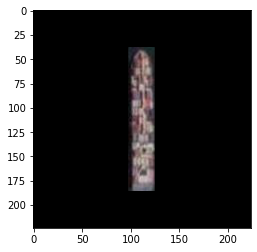

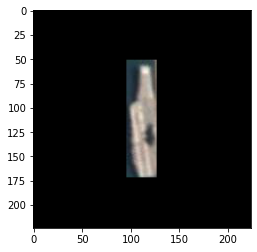

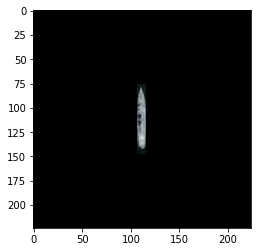

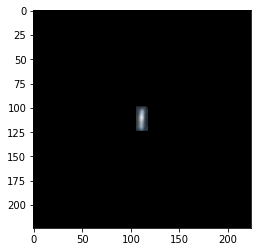

In [31]:
"""
    Count number of dead neurons in a given feature vector
"""
def count_dead_neuron(tensor):
    tensor = tensor.reshape(512)
    binary = (tensor == 0).long()
    num_dead_neuron = (binary.sum()).numpy()
    
    return num_dead_neuron

"""
Count number of dead neurons of a given image
"""
def investigate(img):
    model.eval()

    h = img.shape[0]
    w = img.shape[1]
    
    img = pad2(img)
    plt.imshow(img)

    tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])


    img = img / 255.
    img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    img = img.transpose(2,0,1)
    img = img.reshape(1,3,224,224)
    img = torch.Tensor(img)

    f = tf_last_layer_chopped(img) # extracted features
    n = count_dead_neuron(f)
    
    print("Ship scale: " + str(h) + " by " + str(w) + " (pixel^2)")
    print(str(n) + " dead neurons.")
    print()

img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Container/2.5_cargo211.jpg")
plt.figure()
plt.imshow(pad2(img))
investigate(img=img)
print("***********************************************")    
    
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Carrier/2.5_ca1.jpg")
plt.figure()
plt.imshow(pad2(img))
investigate(img=img)
print("***********************************************")

img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Warship/2.5_war55_1.jpg")
plt.figure()
plt.imshow(pad2(img))
investigate(img=img)
print("***********************************************")

img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Bulk Carrier Small/2.5_bulks94.jpg")
plt.figure()
plt.imshow(pad2(img))
investigate(img=img)
print("***********************************************")


#print(*list(model.children())[:-1])

# Heatmap of activations in extracted feature layer

In [108]:
"""
    Display the neuronal activation of the extracted feature layer with heatmap color
"""
def show_activation(img):
    model.eval()
    tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])
    
    img = pad2(img)
    plt.imshow(img)
    
    img = img / 255.
    img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    img = img.transpose(2,0,1)
    img = img.reshape(1,3,224,224)
    img = torch.Tensor(img)

    final_layer = tf_last_layer_chopped(img) # extracted features   
    final_layer = final_layer.detach().numpy().reshape(512)
    
    f = np.zeros((512, 512))
    for i in range(512):
        f[i].fill(final_layer[i])
    
    sns.heatmap(f, robust=True)

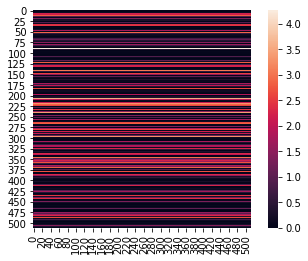

In [109]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Warship/2.5_war38_3.jpg")
show_activation(img)

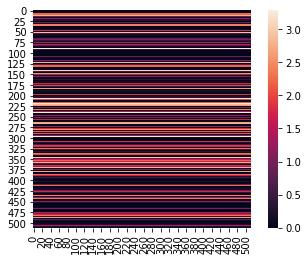

In [99]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Warship/2.5_war38_3.jpg")
show_activation(img)

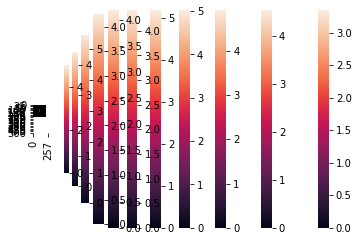

In [79]:
for img_name in os.listdir("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Warship"):
    img = plt.imread(os.path.join("./Downloads/Sat2/Resolutions/Cropped-Ship-2/Warship", img_name))
    show_activation(img)

In [77]:
sn.heatmap(f)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.